In [1]:
import numpy as np
import pandas as pd
import pickle

import tensorflow as tf
import math
import json

from sklearn.model_selection import *
from sklearn import metrics

from daf.datasets import atti_dataset
from daf.utils import dataset_utils
from daf.utils import keras_util

import random

/home/fabio/miniconda3/envs/dl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Use Regularization

In [2]:
(x_train, y_train), (x_test, y_test) = atti_dataset.load_data(num_words=None)
label_index_dict = atti_dataset.get_label_index()

num_words = max([max(x) for x in x_train]) + 1
num_words

52396

In [3]:
print('Total of {} classes'.format(len(label_index_dict)))
label_index_dict

Total of 34 classes


{'ALTRI UFFICI': 0,
 'AVVOCATURA REGIONALE                                  ': 1,
 'D.G.  AVVOCATURA                                      ': 2,
 "D.G. COMPETITIVITA' DEL SISTEMA REGIONALE E SVILUPPO D": 3,
 'D.G. PRESIDENZA                                       ': 4,
 'DIPARTIMENTO BILANCIO E FINANZE                       ': 5,
 'DIPARTIMENTO ORGANIZZAZIONE                           ': 6,
 'DIPARTIMENTO ORGANIZZAZIONE E RISORSE                 ': 7,
 'DIPARTIMENTO POLITICHE FORMATIVE E BENI CULTURALI     ': 8,
 'DIPARTIMENTO POLITICHE TERRITORIALI E AMBIENTALI      ': 9,
 'DIPARTIMENTO PRESIDENZA AFFARI LEGISLATIVI E GIURIDICI': 10,
 'DIPARTIMENTO SALUTE E POLITICHE SOLIDARIETA           ': 11,
 'DIPARTIMENTO SVILUPPO ECONOMICO                       ': 12,
 'DIREZIONE AFFARI LEGISLATIVI, GIURIDICI ED ISTITUZIONALI': 13,
 'DIREZIONE AGRICOLTURA E SVILUPPO RURALE': 14,
 "DIREZIONE ATTIVITA' PRODUTTIVE": 15,
 'DIREZIONE CULTURA E RICERCA': 16,
 'DIREZIONE DIFESA DEL SUOLO E PROTEZIONE CIV

## Data Preparation

create the function to trasnform the x data

In [4]:
from functools import partial

def x_transformer(x_data):
    return partial(dataset_utils.vectorize_sequences, x_data, num_words)

def y_tranformer(y_data):
    return partial(dataset_utils.to_one_hot, y_data, num_classes)

In [5]:
batch_size = 128
num_classes = len(set(y_train))
train_val_split = math.ceil(len(x_train) * 0.8)
print('num classes {}'.format(num_classes))
print('training size {}, validation size {}'.format(train_val_split, len(x_train) - train_val_split))

num classes 34
training size 117777, validation size 29444


In [6]:
train_generator = dataset_utils.dataset_generator_fun(x_train, y_train, x_transformer, y_tranformer, 
                                                      batch_size, 0, train_val_split, True)

val_generator = dataset_utils.dataset_generator_fun(x_train, y_train, x_transformer, y_tranformer,
                                                    batch_size, train_val_split, len(x_train), False)

train_steps = train_val_split // batch_size + 1
val_steps = (len(x_train) - train_val_split) // batch_size + 1

## Build the Models

apart the base model we add new methods with different kind of regularizers. In particular, we take into account:
- l2 that penalize the weights coefficient with a value proportional of their l1 and l2 norms. The general idea is that we prefer a simple model where the distribution of parameters values has less entropy.
- dropout where the idea is to reset randomly a percentage of the weights to zero in order to avoid that neurons start to memorize noise patterns.

In [7]:
def build_base_model(neurons, num_words, num_classes):
    keras_util.new_session()
    input_l = tf.keras.Input(shape=(num_words, ))
    l = tf.keras.layers.Dense(neurons, activation='relu')(input_l)
    l = tf.keras.layers.Dense(neurons, activation='relu')(l)
    l = tf.keras.layers.Dense(neurons, activation='relu')(l)
    output_l = tf.keras.layers.Dense(num_classes, activation='softmax')(l)
    model = tf.keras.Model(inputs=input_l, outputs=output_l)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [17]:
def build_l2_model(neurons, num_words, num_classes):
    keras_util.new_session()
    input_l = tf.keras.Input(shape=(num_words, ))
    l = tf.keras.layers.Dense(neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_l)
    l = tf.keras.layers.Dense(neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(l)
    l = tf.keras.layers.Dense(neurons, activation='relu')(l)
    output_l = tf.keras.layers.Dense(num_classes, activation='softmax')(l)
    model = tf.keras.Model(inputs=input_l, outputs=output_l)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [9]:
def build_dropout_model(neurons, num_words, num_classes, dropout=0.5):
    keras_util.new_session()
    input_l = tf.keras.Input(shape=(num_words, ))
    l = tf.keras.layers.Dense(neurons, activation='relu')(input_l)
    l = tf.keras.layers.Dropout(dropout)(l)
    l = tf.keras.layers.Dense(neurons, activation='relu')(l)
    l = tf.keras.layers.Dropout(dropout)(l)
    l = tf.keras.layers.Dense(neurons, activation='relu')(l)
    output_l = tf.keras.layers.Dense(num_classes, activation='softmax')(l)
    model = tf.keras.Model(inputs=input_l, outputs=output_l)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [18]:
def train(neurons, epochs):
    histories = {}
    models = {
        "l2_regularization": build_l2_model,
        "droupout_regularization": build_dropout_model
    }
    for name, model_f in models.items():
        model = model_f(neurons, num_words, num_classes)
        print(model.summary())
        
        callbacks = [
            tf.keras.callbacks.TensorBoard(log_dir="logs/{}_{}".format(name, neurons)),
            tf.keras.callbacks.EarlyStopping(patience=3, verbose=1),
            tf.keras.callbacks.ReduceLROnPlateau(patience=3)
            ]  
        
        history = model.fit_generator(train_generator, steps_per_epoch=train_steps, epochs=epochs, 
                      validation_data=val_generator, validation_steps=val_steps, callbacks=callbacks)

        histories[name] = history

In [19]:
histories = train(512, 10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 52396)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               26827264  
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 34)                17442     
Total params: 27,370,018
Trainable params: 27,370,018
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
921/921 [==============================] - 78s 85ms/step - loss: 1.7184 - acc: 0.6278 - val_loss: 1.6828 - val_acc

## Build the final model

the best model is obtained with 512 neurons and 3 epochs

In [20]:
train_steps = len(x_train) // batch_size + 1

train_generator = dataset_utils.dataset_generator_fun(x_train, y_train, x_transformer, y_tranformer, 
                                                      batch_size, 0, len(x_train), True)

In [21]:
model = build_dropout_model(512, num_words, num_classes)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 52396)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               26827264  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 34)                17442     
Total para

In [22]:
history = model.fit_generator(train_generator, train_steps, 6)

Epoch 1/6
1151/1151 [==============================] - 77s 67ms/step - loss: 1.1596 - acc: 0.6305
Epoch 2/6
1151/1151 [==============================] - 76s 66ms/step - loss: 0.6960 - acc: 0.7685
Epoch 3/6
1151/1151 [==============================] - 76s 66ms/step - loss: 0.5562 - acc: 0.8142
Epoch 4/6
1151/1151 [==============================] - 76s 66ms/step - loss: 0.4709 - acc: 0.8422
Epoch 5/6
1151/1151 [==============================] - 76s 66ms/step - loss: 0.4105 - acc: 0.8628
Epoch 6/6
1151/1151 [==============================] - 76s 66ms/step - loss: 0.3767 - acc: 0.8743


In [24]:
import gc
gc.collect()

50239

## Evaluate on the test set

In [26]:
x_test_v = dataset_utils.vectorize_sequences(x_test, num_words)
y_test_v = dataset_utils.to_one_hot(y_test, num_classes)

In [27]:
test_predictions = model.predict(x_test_v, verbose=1)

36806/36806 [==============================] - 9s 232us/step


In [28]:
predictions = np.array([np.argmax(x) for x in test_predictions])
precision, recall, fscore, _ = metrics.precision_recall_fscore_support(y_test,predictions, average='weighted')
accuracy = metrics.accuracy_score(y_test, predictions)

auc_score = metrics.roc_auc_score(y_test_v, test_predictions, average='weighted')

print('accuracy ', accuracy)
print('precision ', precision)
print('recall ', recall)
print('f-measure ', fscore)

accuracy  0.7640330380916155
precision  0.7702782184432552
recall  0.7640330380916155
f-measure  0.7635017711838226


### Report the classification result for each class

In [29]:
print(metrics.classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.66      0.49      0.56       212
          1       0.72      0.43      0.54       228
          2       0.83      0.91      0.87       718
          3       0.78      0.68      0.72      3150
          4       0.72      0.78      0.75      2488
          5       0.61      0.65      0.63       306
          6       0.58      0.63      0.61       651
          7       0.55      0.36      0.44       350
          8       0.69      0.68      0.68       771
          9       0.78      0.78      0.78      1759
         10       0.73      0.63      0.68       777
         11       0.73      0.56      0.63      1037
         12       0.76      0.62      0.69      1177
         13       0.70      0.39      0.51       175
         14       0.96      0.94      0.95      2812
         15       0.71      0.76      0.74       432
         16       0.64      0.61      0.63       194
         17       0.93      0.93      0.93   

### Confusion Matrix

In [30]:
conf_matrix = metrics.confusion_matrix(y_test, predictions)

In [31]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
np.set_printoptions(precision=2)

Confusion matrix, without normalization


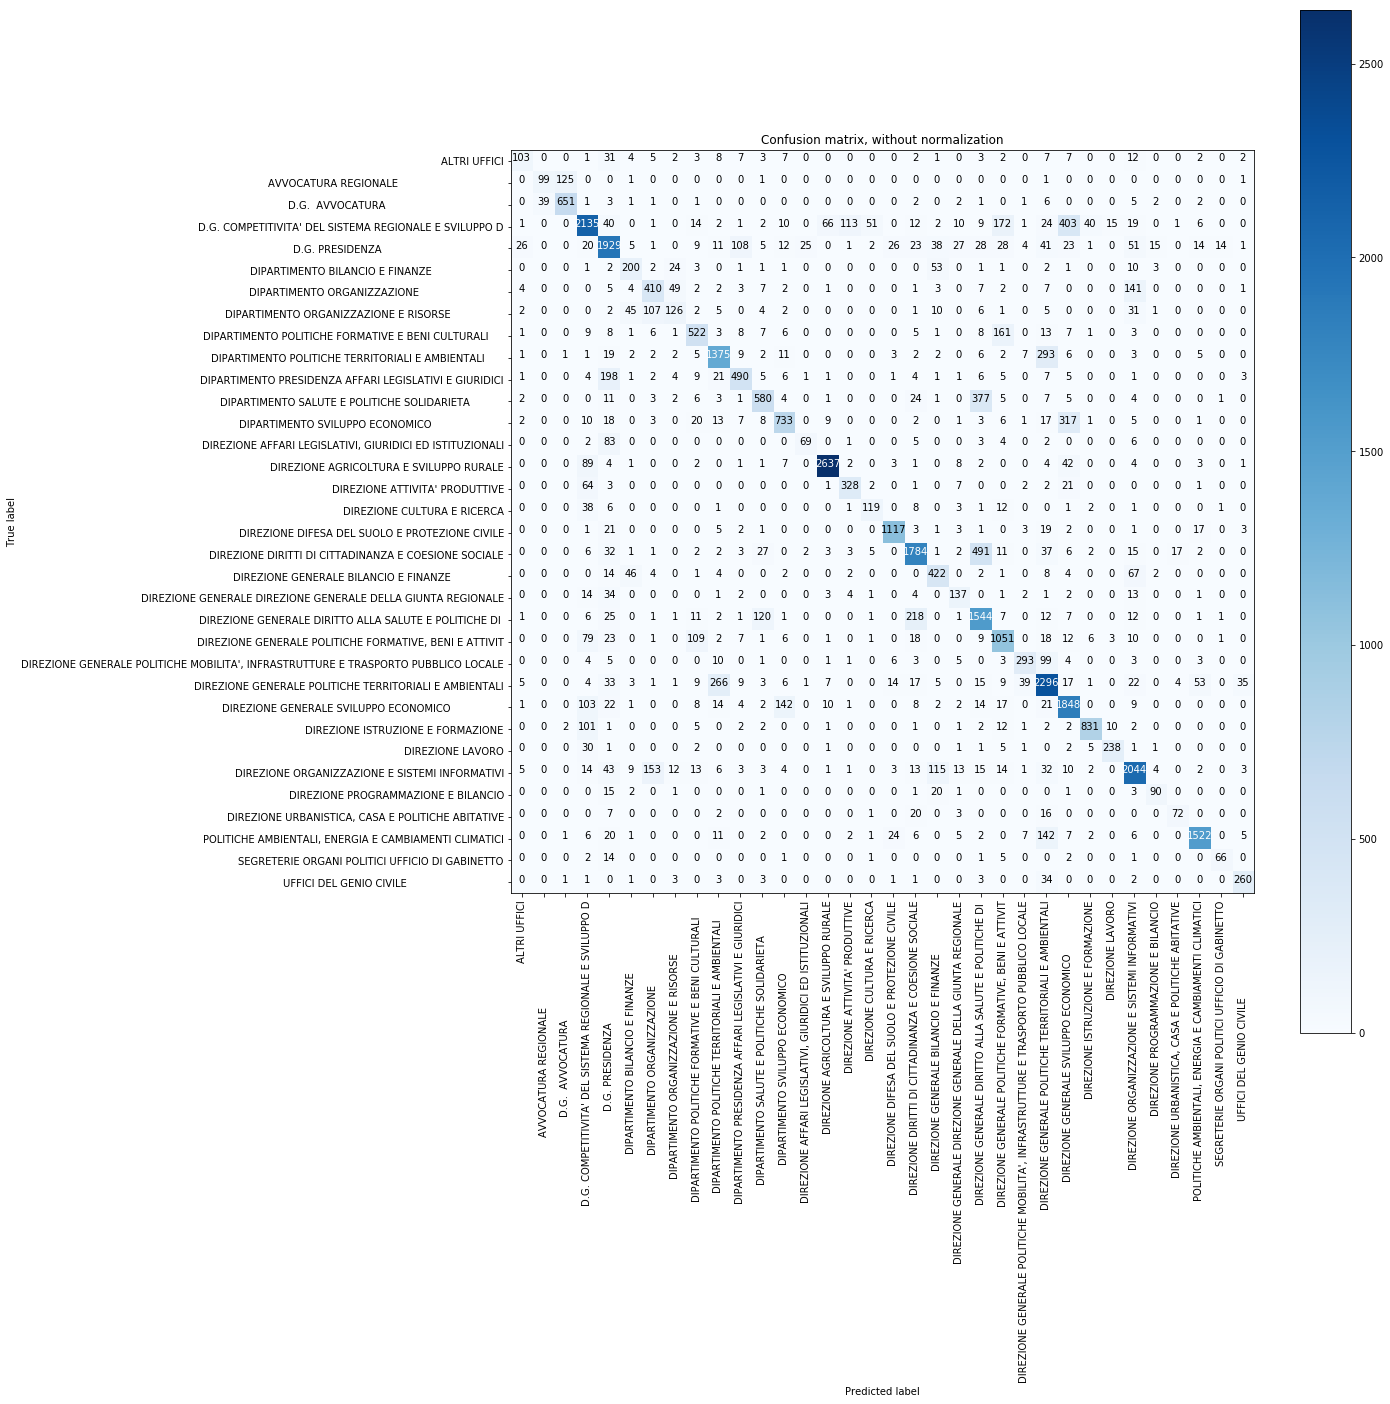

In [32]:
plt.rcParams['figure.figsize'] = (20,20)
plot_confusion_matrix(conf_matrix, classes=label_index_dict,
                      title='Confusion matrix, without normalization')